# Using `matplotlib` to display inline images <a href="https://mybinder.org/v2/gh/InsightSoftwareConsortium/SimpleITK-Notebooks/master?filepath=Python%2F10_matplotlib's_imshow.ipynb"><img style="float: right;" src="https://mybinder.org/badge_logo.svg"></a>

In this notebook we will explore using `matplotlib` to display images in our notebooks, and work towards developing a reusable function to display 2D,3D, color, and label overlays for SimpleITK images.

We will also look at the subtleties of working with image filters that require the input images' to be overlapping. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import SimpleITK as sitk

# Download data to work on
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

SimpleITK has a built in `Show` method which saves the image to disk and launches a user configurable program ( defaults to ImageJ ), to display the image. 

In [2]:
img1 = sitk.ReadImage(fdata("cthead1.png"))
hello_world = 42 ### original line was sITK.Show(img1, title="cthead1")

Fetching cthead1.png


libpng warning: sCAL: invalid unit
libpng warning: sCAL: invalid unit
libpng warning: sCAL: invalid unit


In [3]:
img2 = sitk.ReadImage(fdata("VM1111Shrink-RGB.png"))
hello_world = 42 ### original line was sITK.Show(img2, title="Visible Human Head")

Fetching VM1111Shrink-RGB.png


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


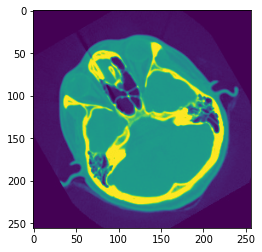

In [4]:
nda = sitk.GetArrayViewFromImage(img1)
plt.imshow(nda)

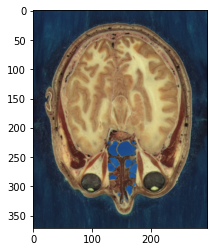

In [5]:
nda = sitk.GetArrayViewFromImage(img2)
ax = plt.imshow(nda)

In [6]:
def myshow(img):
    nda = sitk.GetArrayViewFromImage(img)
    plt.imshow(nda)

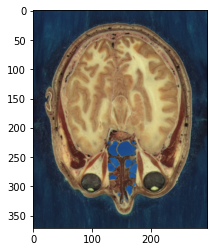

In [7]:
myshow(img2)

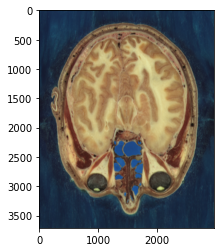

In [8]:
myshow(sitk.Expand(img2, [10] * 5))

This image does not appear bigger.

There are numerous improvements that we can make:

 - support 3d images
 - include a title
 - use physical pixel size for axis labels
 - show the image as gray values

In [9]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()

    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]

        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3, 4):
            nda = nda[nda.shape[0] // 2, :, :]

    elif nda.ndim == 4:
        c = nda.shape[-1]

        if not c in (3, 4):
            raise Runtime("Unable to show 3D-vector Image")

        # take a z-slice
        nda = nda[nda.shape[0] // 2, :, :, :]

    ysize = nda.shape[0]
    xsize = nda.shape[1]

    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2 * margin, 1 - 2 * margin])

    extent = (0, xsize * spacing[1], ysize * spacing[0], 0)

    t = ax.imshow(nda, extent=extent, interpolation=None)

    if nda.ndim == 2:
        t.set_cmap("gray")

    if title:
        plt.title(title)

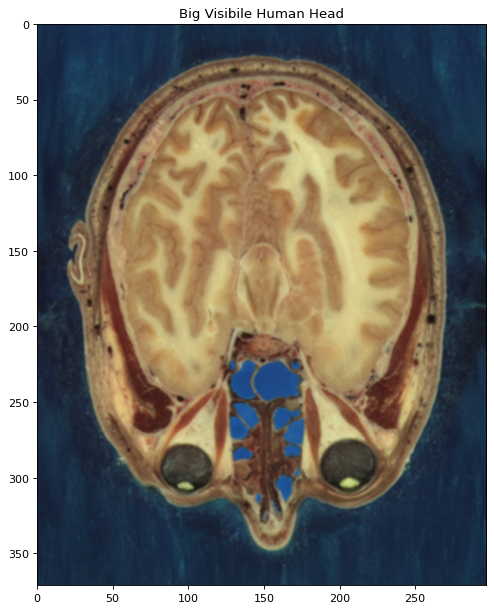

In [10]:
myshow(sitk.Expand(img2, [2, 2]), title="Big Visibile Human Head")

## Tips and Tricks for Visualizing Segmentations

We start by loading a segmented image. As the segmentation is just an image with integral data, we can display the labels as we would any other image.

Fetching 2th_cthead1.png


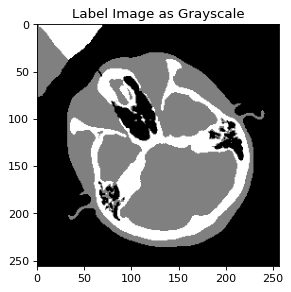

In [11]:
img1_seg = sitk.ReadImage(fdata("2th_cthead1.png"))
myshow(img1_seg, "Label Image as Grayscale")

We can also map the scalar label image to a color image as shown below.

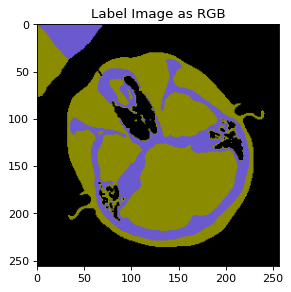

In [12]:
myshow(sitk.LabelToRGB(img1_seg), title="Label Image as RGB")

Most filters which take multiple images as arguments require that the images occupy the same physical space. That is the pixel you are operating must refer to the same location. Luckily for us our image and labels do occupy the same physical space, allowing us to overlay the segmentation onto the original image.

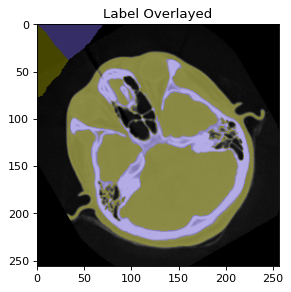

In [13]:
myshow(sitk.LabelOverlay(img1, img1_seg), title="Label Overlayed")

We can also overlay the labels as contours.

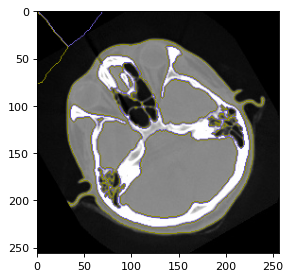

In [14]:
myshow(sitk.LabelOverlay(img1, sitk.LabelContour(img1_seg), 1.0))

## Tips and Tricks for 3D Image Visualization

Now lets move on to visualizing real MRI images with segmentations. The Surgical Planning Laboratory at Brigham and Women's Hospital provides a wonderful Multi-modality MRI-based Atlas of the Brain that we can use.

Please note, what is done here is for convenience and is not the common way images are displayed for radiological work.

In [15]:
img_T1 = sitk.ReadImage(fdata("nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT1.nrrd"))
img_T2 = sitk.ReadImage(fdata("nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT2.nrrd"))
img_labels = sitk.ReadImage(
    fdata("nac-hncma-atlas2013-Slicer4Version/Data/hncma-atlas.nrrd")
)

Fetching nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT1.nrrd
Fetching nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT2.nrrd
Fetching nac-hncma-atlas2013-Slicer4Version/Data/hncma-atlas.nrrd


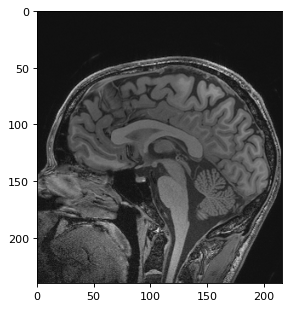

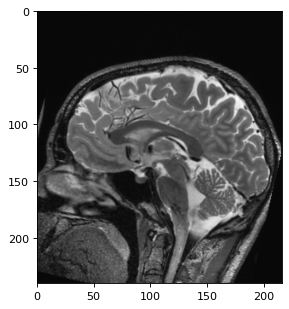

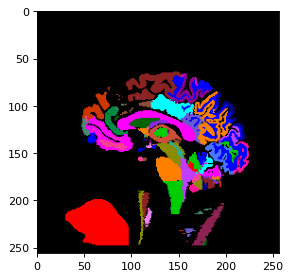

In [16]:
myshow(img_T1)
myshow(img_T2)
myshow(sitk.LabelToRGB(img_labels))

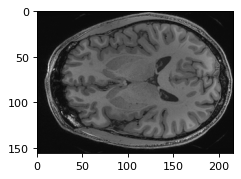

In [17]:
size = img_T1.GetSize()
myshow(img_T1[:, size[1] // 2, :])

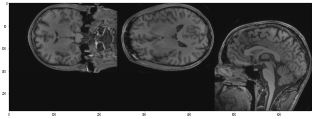

In [18]:
slices = [
    img_T1[size[0] // 2, :, :],
    img_T1[:, size[1] // 2, :],
    img_T1[:, :, size[2] // 2],
]
myshow(sitk.Tile(slices, [3, 1]), dpi=20)

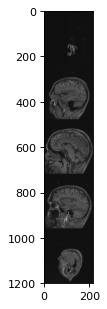

In [19]:
nslices = 5
slices = [img_T1[:, :, s] for s in range(0, size[2], size[0] // (nslices + 1))]
myshow(sitk.Tile(slices, [1, 0]))

Let's create a version of the show methods which allows the selection of slices to be displayed.

In [20]:
def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05, dpi=80):
    size = img.GetSize()
    img_xslices = [img[s, :, :] for s in xslices]
    img_yslices = [img[:, s, :] for s in yslices]
    img_zslices = [img[:, :, s] for s in zslices]

    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))

    img_null = sitk.Image([0, 0], img.GetPixelID(), img.GetNumberOfComponentsPerPixel())

    img_slices = []
    d = 0

    if len(img_xslices):
        img_slices += img_xslices + [img_null] * (maxlen - len(img_xslices))
        d += 1

    if len(img_yslices):
        img_slices += img_yslices + [img_null] * (maxlen - len(img_yslices))
        d += 1

    if len(img_zslices):
        img_slices += img_zslices + [img_null] * (maxlen - len(img_zslices))
        d += 1

    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen, d])
        # TO DO check in code to get Tile Filter working with vector images
        else:
            img_comps = []
            for i in range(0, img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i) for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen, d]))
            img = sitk.Compose(img_comps)

    myshow(img, title, margin, dpi)

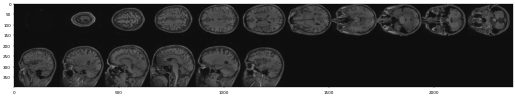

In [21]:
myshow3d(
    img_T1,
    yslices=range(50, size[1] - 50, 20),
    zslices=range(50, size[2] - 50, 20),
    dpi=30,
)

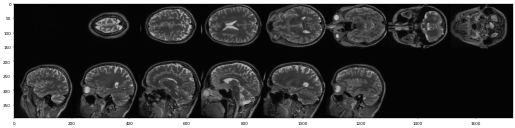

In [22]:
myshow3d(
    img_T2,
    yslices=range(50, size[1] - 50, 30),
    zslices=range(50, size[2] - 50, 20),
    dpi=30,
)

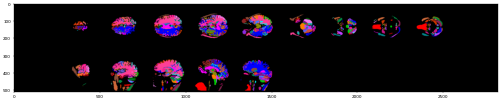

In [23]:
myshow3d(
    sitk.LabelToRGB(img_labels),
    yslices=range(50, size[1] - 50, 20),
    zslices=range(50, size[2] - 50, 20),
    dpi=30,
)

We next visualize the T1 image with an overlay of the labels.

In [24]:
# Why doesn't this work? The images do overlap in physical space.
myshow3d(
    sitk.LabelOverlay(img_T1, img_labels),
    yslices=range(50, size[1] - 50, 20),
    zslices=range(50, size[2] - 50, 20),
    dpi=30,
)

RuntimeError: Exception thrown in SimpleITK LabelOverlay: /Users/runner/work/1/sitk/Code/BasicFilters/src/sitkImageFilter.cxx:63:
sitk::ERROR: Input "labelImage" for "LabelOverlayImageFilter" has size of [ 256, 256, 256 ] which does not match the primary input's size of [ 288, 320, 208 ]!

Two ways to solve our problem: (1) resample the labels onto the image grid (2) resample the image onto the label grid. The difference between the two from a computation standpoint depends on the grid sizes and on the interpolator used to estimate values at non-grid locations. 

Note interpolating a label image with an interpolator that can generate non-label values is problematic as you may end up with an image that has more classes/labels than your original. This is why we only use the nearest neighbor interpolator when working with label images.

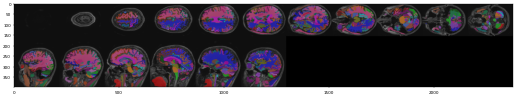

In [25]:
# Option 1: Resample the label image using the identity transformation
resampled_img_labels = sitk.Resample(
    img_labels,
    img_T1,
    sitk.Transform(),
    sitk.sitkNearestNeighbor,
    0.0,
    img_labels.GetPixelID(),
)
# Overlay onto the T1 image, requires us to rescale the intensity of the T1 image to [0,255] and cast it so that it can
# be combined with the color overlay (we use an alpha blending of 0.5).
myshow3d(
    sitk.LabelOverlay(
        sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8),
        resampled_img_labels,
        0.5,
    ),
    yslices=range(50, size[1] - 50, 20),
    zslices=range(50, size[2] - 50, 20),
    dpi=30,
)

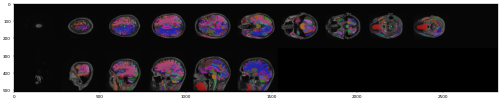

In [26]:
# Option 2: Resample the T1 image using the identity transformation
resampled_T1 = sitk.Resample(
    img_T1, img_labels, sitk.Transform(), sitk.sitkLinear, 0.0, img_T1.GetPixelID()
)
# Overlay onto the T1 image, requires us to rescale the intensity of the T1 image to [0,255] and cast it so that it can
# be combined with the color overlay (we use an alpha blending of 0.5).
myshow3d(
    sitk.LabelOverlay(
        sitk.Cast(sitk.RescaleIntensity(resampled_T1), sitk.sitkUInt8), img_labels, 0.5
    ),
    yslices=range(50, size[1] - 50, 20),
    zslices=range(50, size[2] - 50, 20),
    dpi=30,
)

Why are the two displays above different? (hint: in the calls to the "myshow3d" function the indexes of the y and z slices are the same). 

The ``myshow`` and ``myshow3d`` functions are really useful. They have been copied into a "myshow.py" file so that they can be imported into other notebooks.